In [10]:
%load_ext autoreload
%autoreload 2

## Imports

In [11]:
import torch
import pathlib
from torch.nn.functional import interpolate
from torcheval.metrics.functional import peak_signal_noise_ratio
from torchmetrics.functional.image import structural_similarity_index_measure
from super_resolution.src.sen2venus_dataset import (
    S2VSite,
    S2VSites,
    create_train_test_split,
)
from super_resolution.src.visualization import plot_gallery

In [2]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data/sites/")

In [3]:
site = S2VSite(
    site_name="FGMANAUS",
    bands="rgbnir",
    download_dir=DATA_DIR,
    device="cpu",
)
print(f"{len(site)} patches")

60
38
2
29
129 patches


In [5]:
def scale_images(images: torch.Tensor) -> torch.Tensor:
    min_val = images.min()
    max_val = images.max()

    return (images - min_val) / (max_val - min_val)


def preprocess_images(images: torch.Tensor, scale_output: bool = True) -> torch.Tensor:
    images = images[:, :3, :, :]
    if scale_output:
        images = scale_images(images)
    return images

In [6]:
X = preprocess_images(
    torch.concat([sentinal_image.unsqueeze(0) for sentinal_image, _ in site]),
    scale_output=False,
)

In [7]:
Y_target = preprocess_images(
    torch.concat([venus_image.unsqueeze(0) for _, venus_image in site]),
    scale_output=False,
)

In [8]:
interpolated_X = interpolate(X, size=(256, 256), mode="bicubic")

In [9]:
psnr = peak_signal_noise_ratio(interpolated_X, Y_target)
ssim = structural_similarity_index_measure(interpolated_X, Y_target)
print(f"PSNR: {psnr}\nSSIM: {ssim}")

PSNR: 47.204368591308594
SSIM: 0.9729371070861816


                       Sentinel                                              Bicubic                                              Venus                       


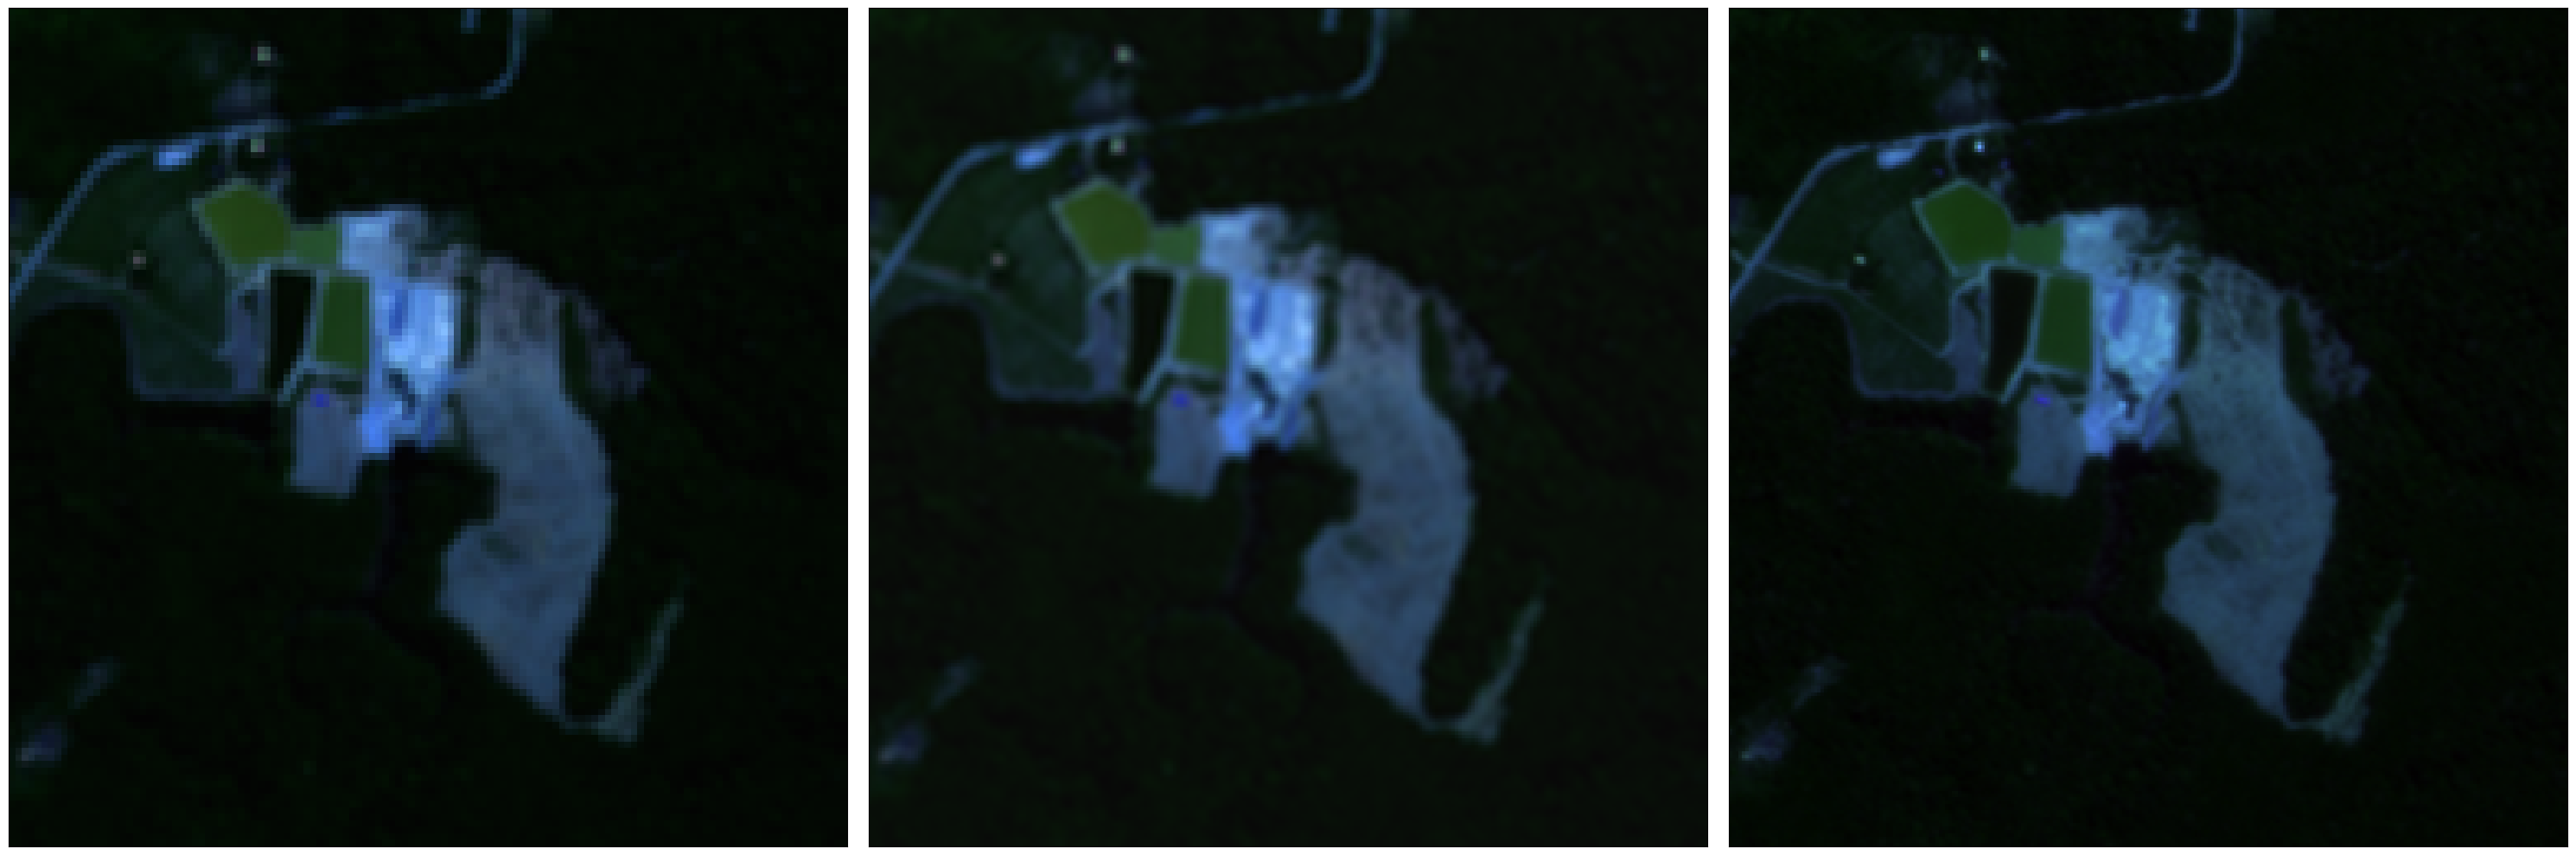

In [11]:
spacing = 23
space = lambda num_space: num_space * " "
print(
    f"{space(spacing)}Sentinel{space(2*spacing)}Bicubic{space(2*spacing)}Venus{space(spacing)}"
)
for i in range(1):
    plot_gallery(
        [
            scale_images(X[i].permute(1, 2, 0)),
            scale_images(interpolated_X[i].permute(1, 2, 0)),
            scale_images(Y_target[i].permute(1, 2, 0)),
        ],
        xscale=10,
        yscale=10,
    )

## Running Bicubic interpolation on different number of samples

In [4]:
site_names = [site_name for site_name, _ in S2VSites.SITES]

In [12]:
num_to_try = 8
for i in range(num_to_try):
    train_data, test_data = create_train_test_split(
        str(DATA_DIR) + "\\", seed=42, sites=set(site_names[:i])
    )

NameError: name 'train_test_split' is not defined